## PyMuPDF
- extracting images from PDF
- extracting texts from different shapes
- making annotations
- draw a bounded box around the texts

extracts tabular data requires manual extra configurations 
1. graphically indicate table and column borders, and 
2. then extract text based on this information.

### Text Data Extractions

In [1]:
import pandas as pd
import numpy as np
from camelot import read_pdf
from pdfminer.high_level import extract_text
import fitz
from collections import Counter
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from PIL import Image, ImageDraw, ImageFont
from datasets import load_dataset

c:\Users\Hazrul Akmal\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Table Extractions
### Camelot Notes

How it works?
1. detect the line in a table

1. can save the extracted data into desired format (ex __.to_excel()) 
    - excel, csv, sqlite, html, json
2. return extracted table in pandas (streamline the data analysis workflow)
3. built-in accuracy and whitespace metrics to stash bad table extractions. 


In [31]:
def read_metrics(table_data):
    """
    table_data : camelot tablelist format
    return a metrics table in pandas dataframe 
    """
    table = {"page":[], "accuracy":[], "whitespace":[]}
    for i in range(table_data.n):
        table["page"].append(i + 1)
        table["accuracy"].append(table_data[i].parsing_report["accuracy"])
        table["whitespace"].append(table_data[i].parsing_report["whitespace"])
    
    return pd.DataFrame(table)
    
# Get all the tables within the file
agm = read_pdf('src/AGM.pdf', pages = '11-21')

# Show the total number of tables in the file
print("Total number of table: {}".format(agm.n))

# print all the tables in the file
#for t in range(all_tables.n):
#    print("Table n°{}".format(t))
#    print((all_tables[t].df).head())

Total number of table: 11


In [32]:
table_df = read_metrics(agm)
table_df

,page,accuracy,whitespace
0,1,100.0,0.00
1,2,100.0,0.00
2,3,100.0,0.00
3,4,100.0,0.00
4,5,100.0,0.00
5,6,100.0,8.33
6,7,100.0,0.00
7,8,100.0,12.50
8,9,100.0,0.00
9,10,0.0,100.00


In [36]:
first_table = agm[1].df #requires adjustments on column names. 
first_table.columns = first_table.iloc[0]
first_table[1:]

,No.,Shareholder/Proxy,Question,Response from the Directors/Management
1,1.,Ong Kok Pak,Will \nthe Company publish all Q&A \nfrom ...,The Company would publish the key matter...
2,2.,Ong Kok Pak,Can the Board of Directors allow the \ns...,T\nThe Board aspires to apply the Practices se...
3,3.,Ong Kok Pak,Currently how many buses and cars \nare ...,"As of end 2020, the Car Rental Division had a ..."
4,4.,Ong Kok Pak,Our \nCompany \ndoes \nhave \nWhistleblower P...,In accordance with Section 17(A) of the Malays...


## Text Extraction

In [8]:
text  = extract_text('src/supervisionletter.pdf', 'rb').split()
print(len(text))

2587


In [17]:
# Get data within the file
pymupdf_text = fitz.open('src/supervisionletter.pdf')

whole_text = []
for page in pymupdf_text:
    text = page.get_text().split()
    print(len(text))
    whole_text += text

print(f" the number of words {len(whole_text)}.")

# build a word dictionary frequency
word_dict = dict(Counter(whole_text))

461
556
569
532
469
 the number of words 2587.


## Financial Statement Extraction


In [37]:
# Get data within the file
financial_statement = fitz.open('src/Financial statement.pdf') #2-5 page have important data

#financial_statement.page_count #to check the number of pages
page1 = financial_statement[1]
first_annots=[]

words= page1.get_text("words")
words[0]

(231.83999633789062,
 29.947208404541016,
 253.3127899169922,
 45.149288177490234,
 'XYZ',
 0,
 0,
 0)

## Scanned Document Extraction

In [44]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),]

def iob_to_label(label):
    label = label[2:]
    if not label:
        return "other"
    return label

def process_image(image, model):
    width, height = image.size

    # encode
    encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop("offset_mapping")

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:, 0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text(
            (box[0] + 10, box[1] - 10),
            text=predicted_label,
            fill=label2color[predicted_label],
            font=font,
        )

    return image

def process_image_edit(image, model):
    width, height = image.size

    # encode
    encoding = processor(image, truncation=True, return_tensors="pt")

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    true_predictions = [id2label[pred] for id, pred in enumerate(predictions)]
    
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes)]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text(
            (box[0] + 10, box[1] - 10),
            text=predicted_label,
            fill=label2color[predicted_label],
            font=font,
        )

    return image

Reusing dataset funsd (C:\Users\Hazrul Akmal\.cache\huggingface\datasets\nielsr___funsd\funsd\1.0.0\8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595)
c:\Users\Hazrul Akmal\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


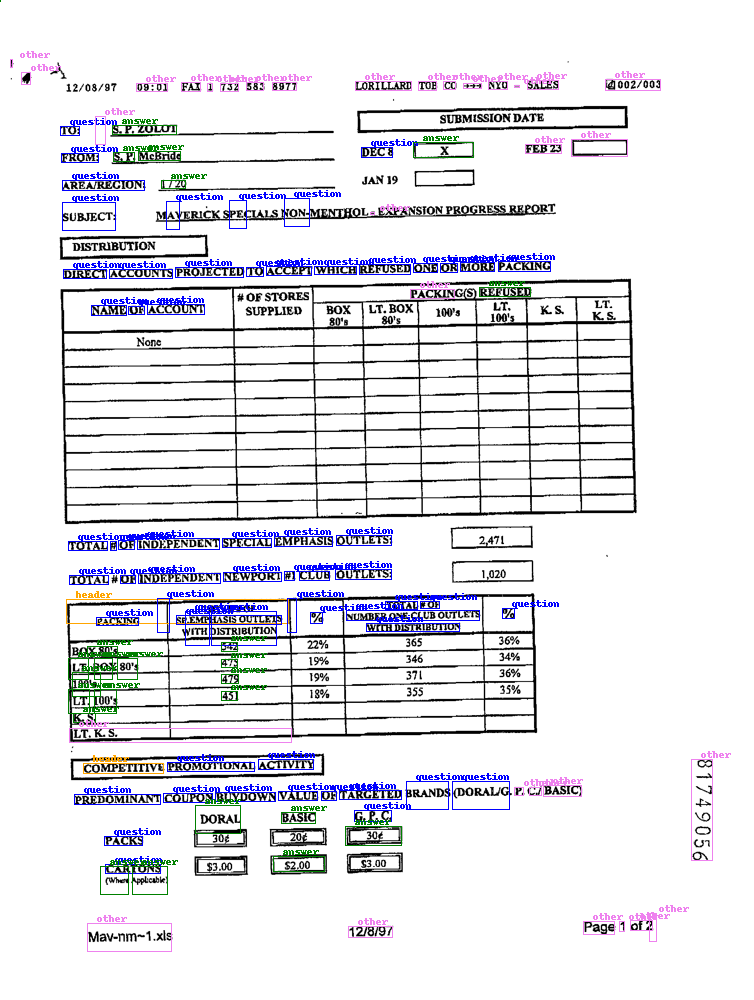

In [18]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
model_finetuned = LayoutLMv3ForTokenClassification.from_pretrained("nielsr/layoutlmv3-finetuned-funsd")

# load image example
dataset = load_dataset("nielsr/funsd", split="test")
#image = Image.open(dataset[0]["image_path"]).convert("RGB")
image = Image.open("src/form photocopy.png").convert("RGB")

labels = dataset.features["ner_tags"].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2color = {"question": "blue","answer": "green","header": "orange","other": "violet",}

process_image(image, model=model_finetuned)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


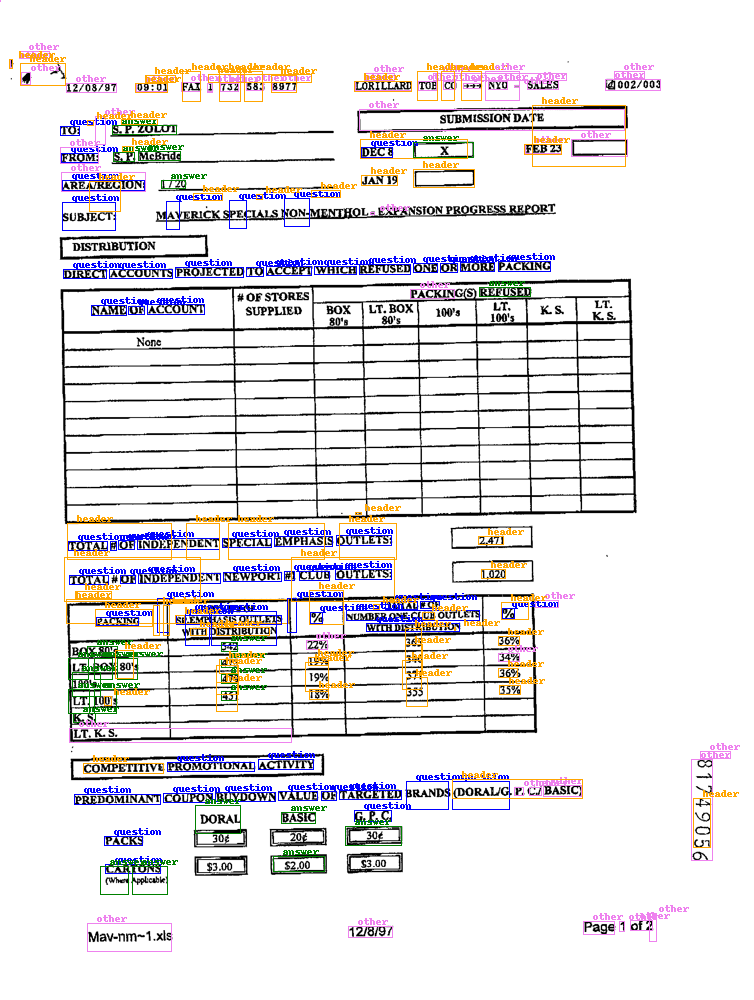

In [19]:
model_ori = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base")

process_image(image, model=model_ori)

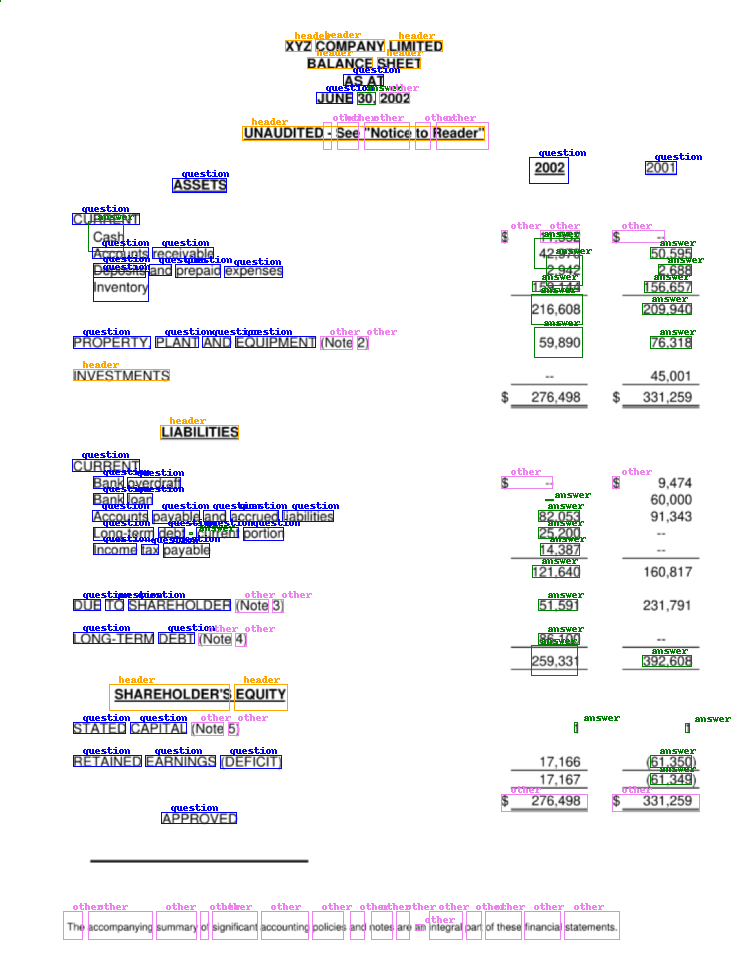

In [26]:
image2 = Image.open("src\Financial statement-2.png").convert("RGB")
process_image(image2, model=model_finetuned)

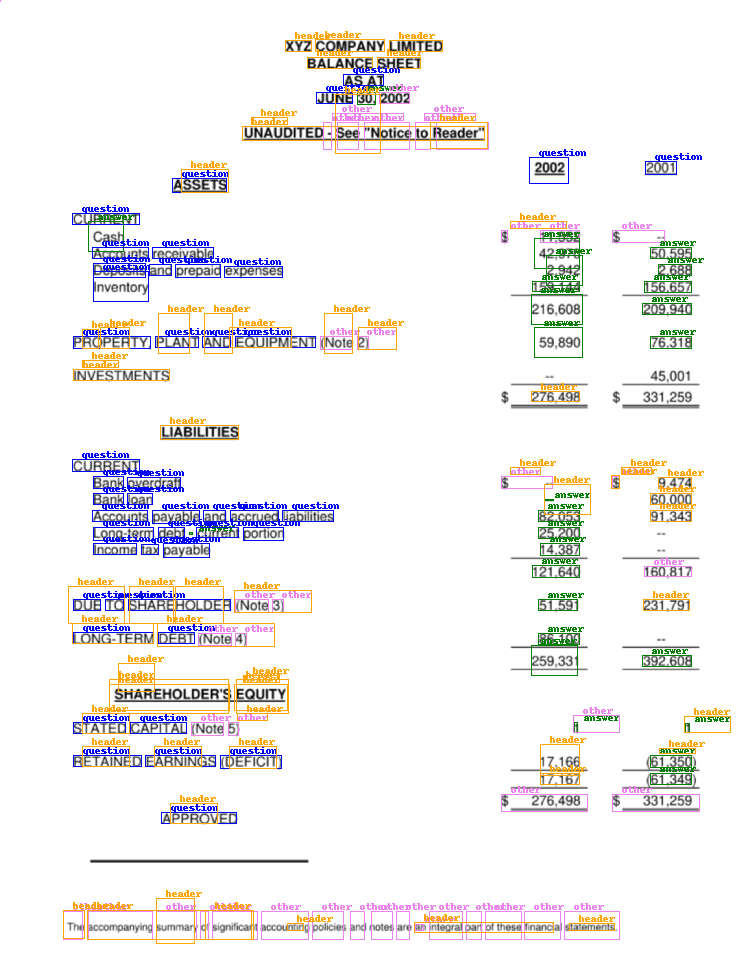

In [27]:
process_image(image2, model=model_ori)

c:\Users\Hazrul Akmal\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


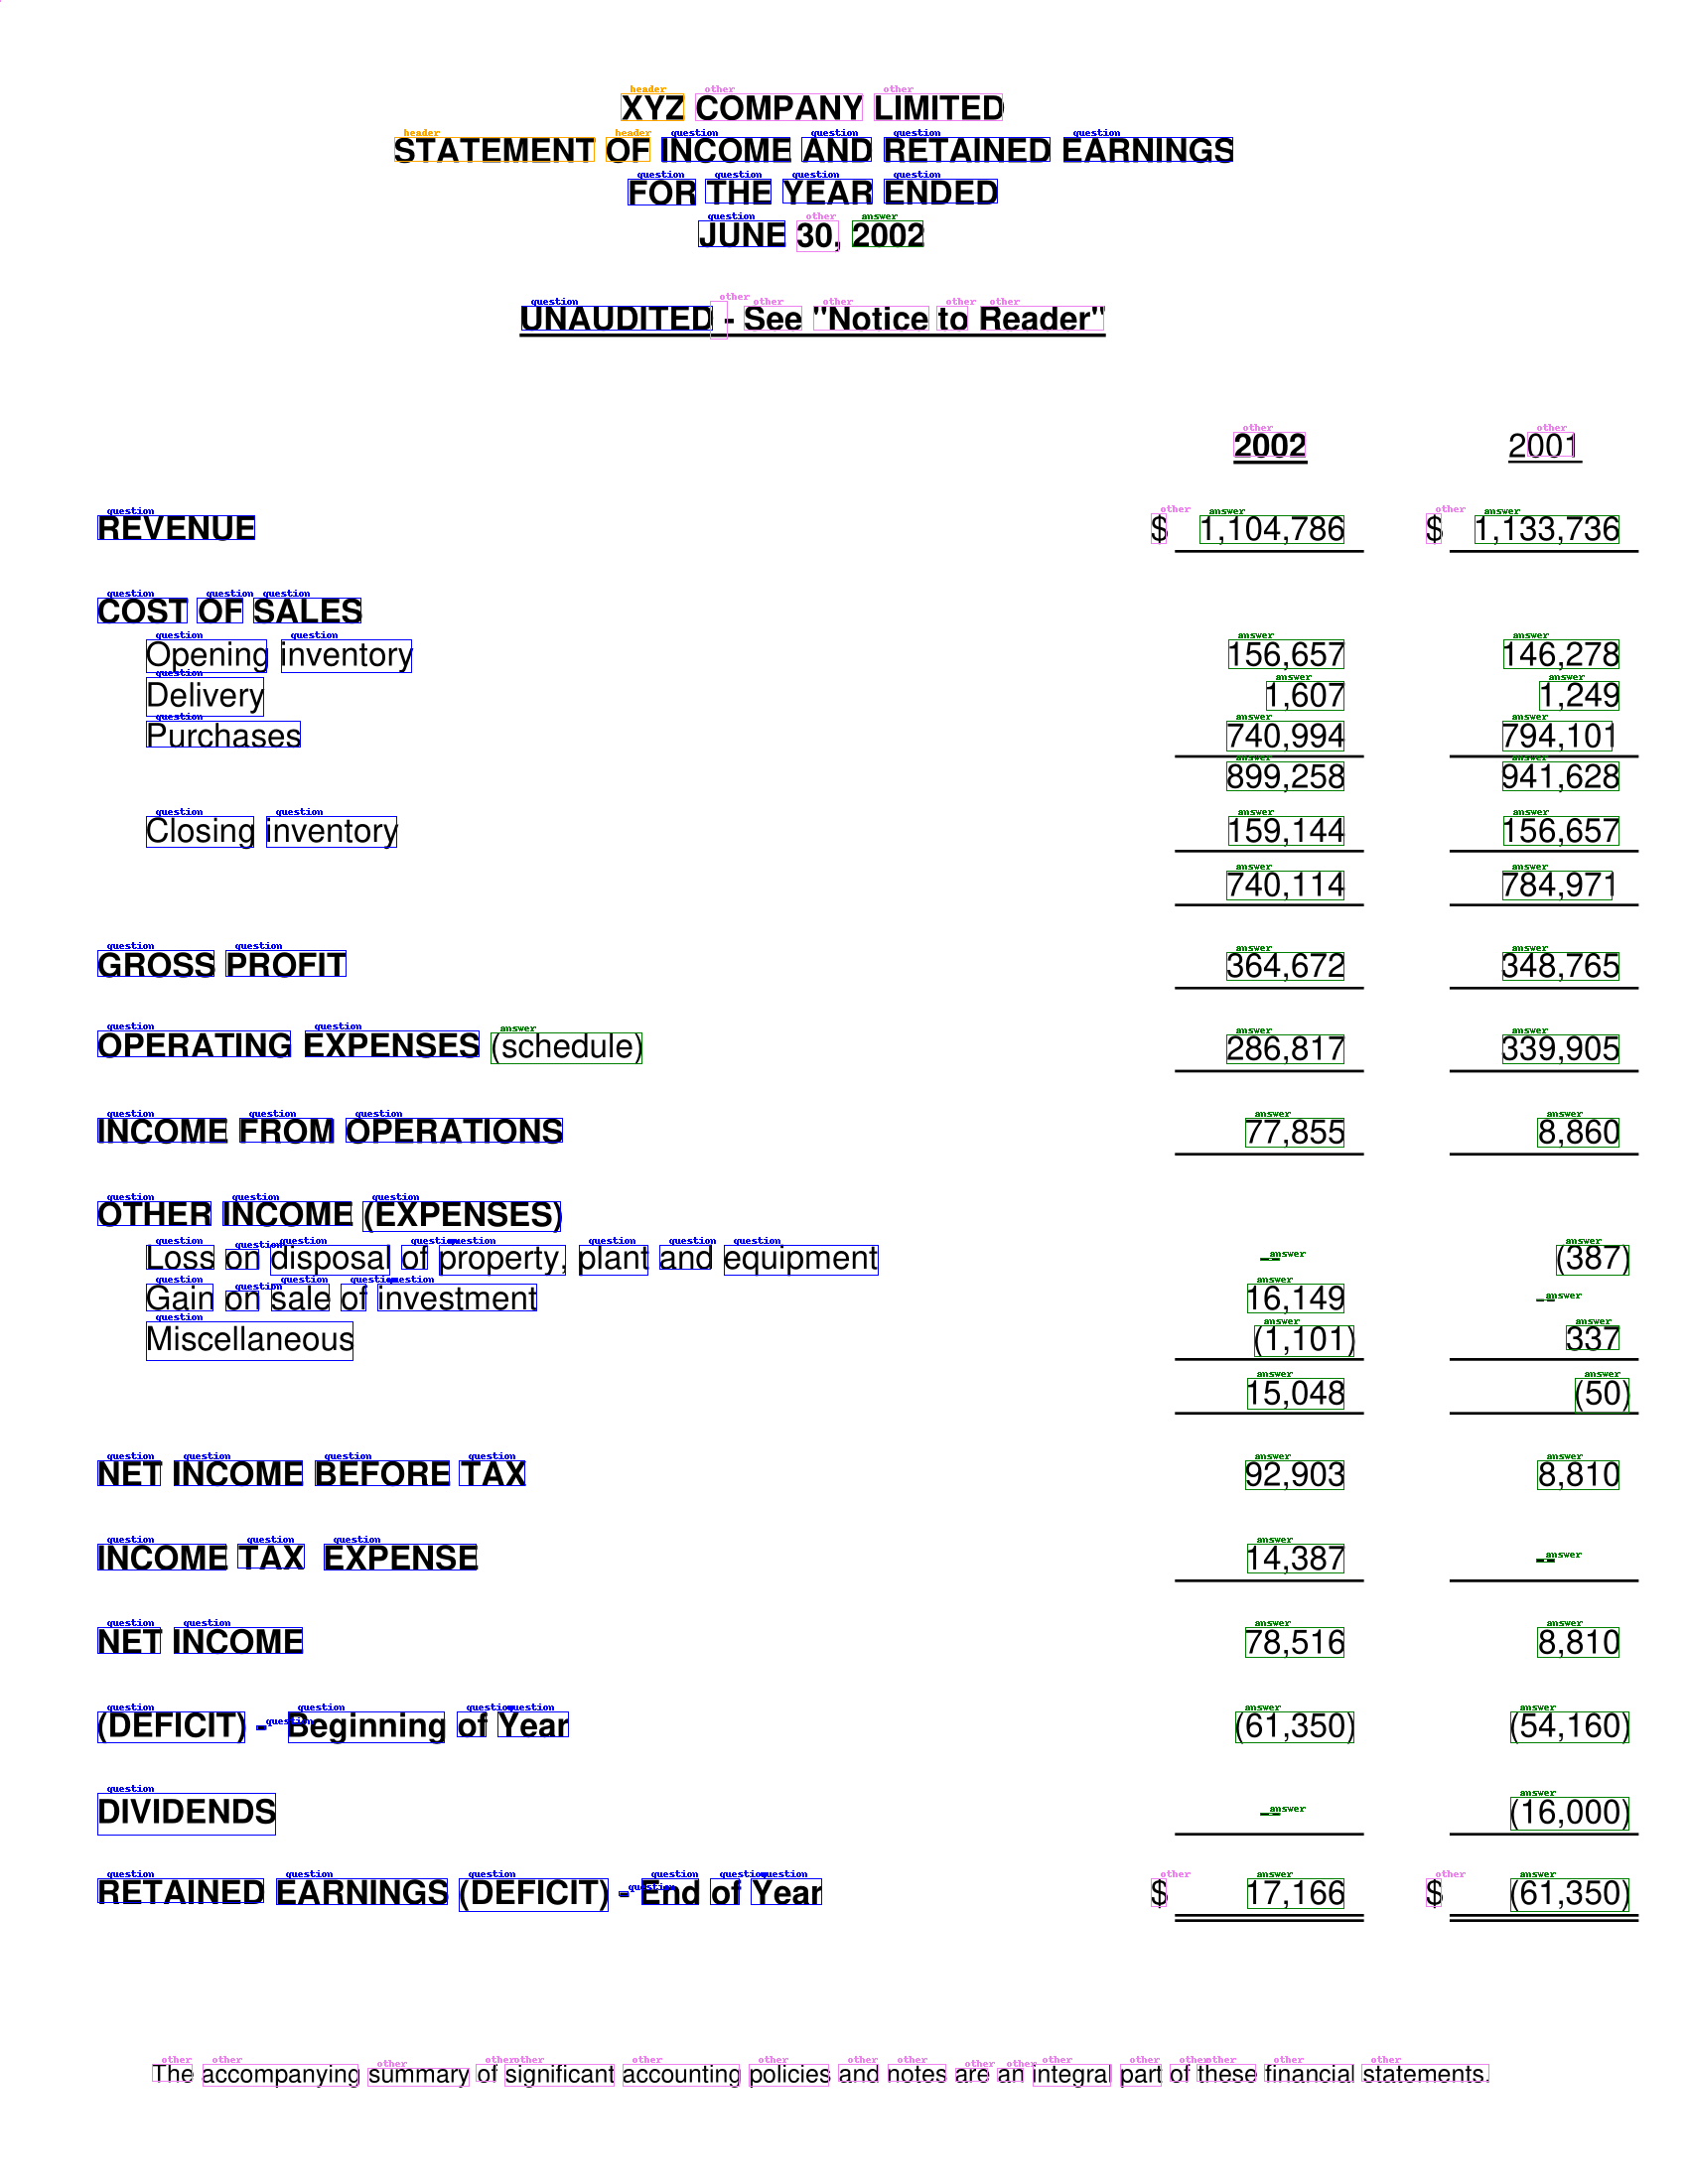

In [29]:
image3 = Image.open("src\Financial statement-3.png").convert("RGB")
process_image(image3, model=model_finetuned)